# Frequency Analysis
## Fourier Transform

The **2D Discrete Fourier Transform (DFT)** of an image $ I(x, y) $ is defined as:
$$ F(u, v) = \sum_{x=0}^{W-1} \sum_{y=0}^{H-1} I(x, y) e^{-j 2\pi \left( \frac{ux}{W} + \frac{vy}{H} \right)} $$

The inverse **Fourier Transform (IDFT)** is given by:
$$ I(x, y) = \frac{1}{WH} \sum_{u=0}^{W-1} \sum_{v=0}^{H-1} F(u, v) e^{j 2\pi \left( \frac{ux}{W} + \frac{vy}{H} \right)} $$

where:
- $ I(x, y) $ – the input image of size $ W \times H $ with spatial coordinates $ (x, y) $.
- $ F(u, v) $ – the Fourier-transformed image in the frequency domain with frequency coordinates $ (u, v) $.
- $ j $ – the imaginary unit where $ j^2 = -1 $.
- the term $ e^{-j 2\pi \left( \frac{ux}{W} + \frac{vy}{H} \right)} $ represents a **complex exponential basis function**, used to decompose the image into sinusoidal components.

**Useful Resources:**
- [Interactive - 1D Fourier Transform](https://www.jezzamon.com/fourier/)
- [YouTube video - 2D Fourier Transform](https://www.youtube.com/watch?v=qa1ZxK9Y1Tw)

**Note:**  
The **Fast Fourier Transform (FFT)** is an **algorithm** for efficiently computing the Discrete Fourier Transform (DFT).

## Magnitude Spectrum in Decibels (dB)
The magnitude of the Fourier transform is often visualized on a **logarithmic scale** to improve contrast. The decibel (dB) representation is computed as:
$$ M_{\text{dB}} = 20 \log_{10} |F(u, v)| $$
- The factor **20** comes from the conversion formula for power magnitude in dB.  
- Since $ \log(0) $ is undefined, we often use $ 20 \log_{10}(|F| + \epsilon) $ to avoid numerical issues.
    - e.g., $ \epsilon $ can be set to 1 to ensure all values remain positive, maintaining a well-scaled representation of the spectrum

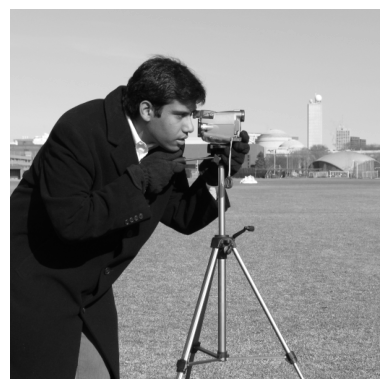

In [1]:
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Load image and convert to grayscale (and then to numpy array)
img_gray = data.camera()

# Display the image
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

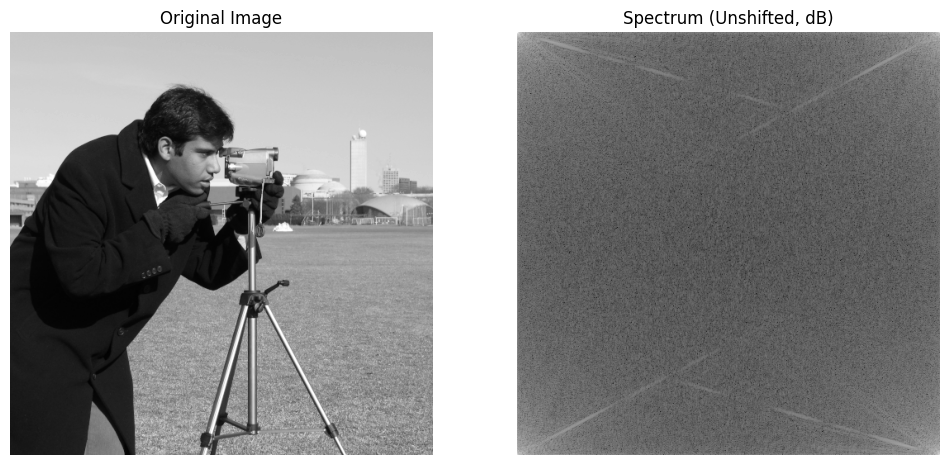

In [2]:
# Compute the Fourier Transform
F = np.fft.fft2(img_gray)

# Magnitude spectrum
F_magnitude = np.abs(F)
# Convert magnitude to logarithmic scale (decibels)
F_magnitude_db = 20 * np.log10(F_magnitude + 1)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Fourier Transform Spectrum
axes[1].imshow(F_magnitude_db, cmap='gray')
axes[1].set_title('Spectrum (Unshifted, dB)')
axes[1].axis('off')

plt.show()

**Note:**  
The default output of the Fourier transform places **low frequencies near the edges** of the image. Since the Fourier 
transform is symmetric, we can **rearrange the quadrants** for better visualization by centering the low frequencies
using the `fftshift()` function:

![fft shift](https://3.bp.blogspot.com/-V1jgTpxSHBA/UeK1Z-eUgcI/AAAAAAAAAS4/meL_n_lNn1w/s1600/3rdresult_paint.PNG)

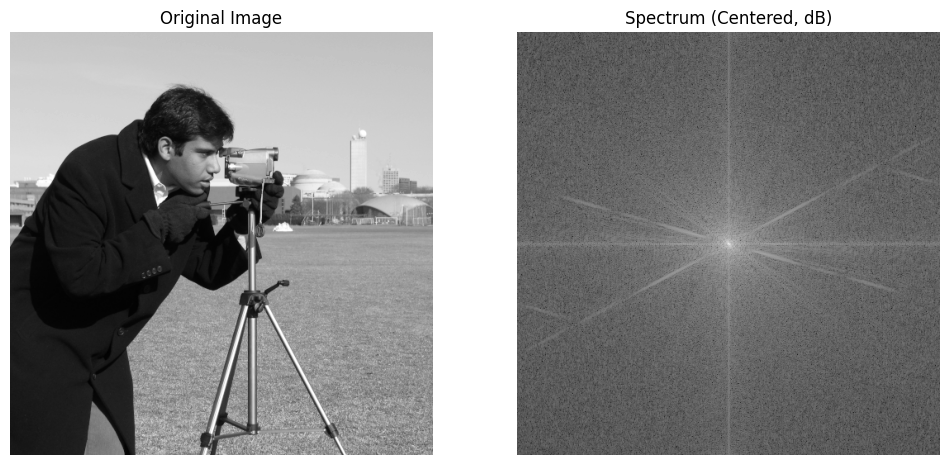

In [3]:
# Shift the magnitude spectrum to center the low frequencies
F_magnitude_db_shifted = np.fft.fftshift(F_magnitude_db)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Fourier Transform Spectrum (shifted/centered)
axes[1].imshow(F_magnitude_db_shifted, cmap='gray')
axes[1].set_title('Spectrum (Centered, dB)')
axes[1].axis('off')

plt.show()

**Note:**  
Lines in the spectrum appear rotated by **90 degrees** relative to the patterns in the original image.  
- **Horizontal edges** in the image → **Vertical lines** in the spectrum.  
- **Vertical edges** in the image → **Horizontal lines** in the spectrum.


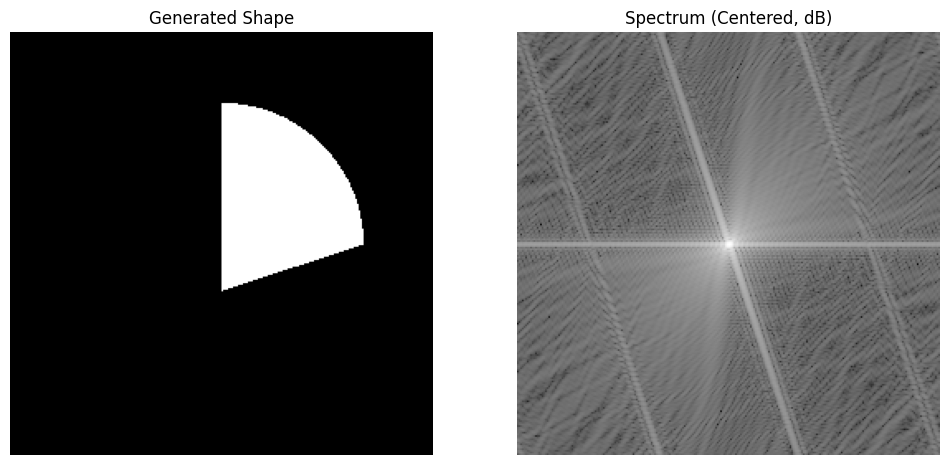

In [4]:
from PIL import Image, ImageDraw

# Create synthetic image...
size = 256
img_syn = Image.new('L', (size, size), 0)
draw = ImageDraw.Draw(img_syn)

# Define circle parameters and draw it
center = (size // 2, size // 2)
radius = size // 3
draw.ellipse((center[0] - radius, center[1] - radius,
              center[0] + radius, center[1] + radius), fill=255)

# Convert to NumPy array
img_array = np.array(img_syn)
img_array[:, :center[0]] = 0  # remove the left half
img_array[center[1]:, :] = 0  # remove the bottom half

# Create a new image for drawing the triangle
img_syn = Image.fromarray(img_array)
draw = ImageDraw.Draw(img_syn)

# Define correct triangle points and draw it
lowest_point = (center[0], center[1] + radius // 3)  # original lowest point of the circle reduced in y-axis
rightmost_point = (center[0] + radius, center[1])    # rightmost point on the circle
triangle = [lowest_point, rightmost_point, center]   # correct triangle vertices
draw.polygon(triangle, fill=255)

# Convert back to NumPy array
img_array = np.array(img_syn)

# Compute FFT
F = np.fft.fft2(img_array)
F_magnitude_syn = np.abs(F)
F_magnitude_db_syn = 20 * np.log10(F_magnitude_syn + 1)
F_magnitude_db_shifted_syn = np.fft.fftshift(F_magnitude_db_syn)

# Plot original image and its FFT
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title('Generated Shape')
axes[0].axis('off')

axes[1].imshow(F_magnitude_db_shifted_syn, cmap='gray')
axes[1].set_title('Spectrum (Centered, dB)')
axes[1].axis('off')

plt.show()

## Low-Pass and High-Pass Filters
- **Low-Pass Filter**: retains **low-frequency components**, highlighting large objects while reducing fine details and noise
- **High-Pass Filter**: retains **high-frequency components**, enhancing edges and textures by removing large-scale variations

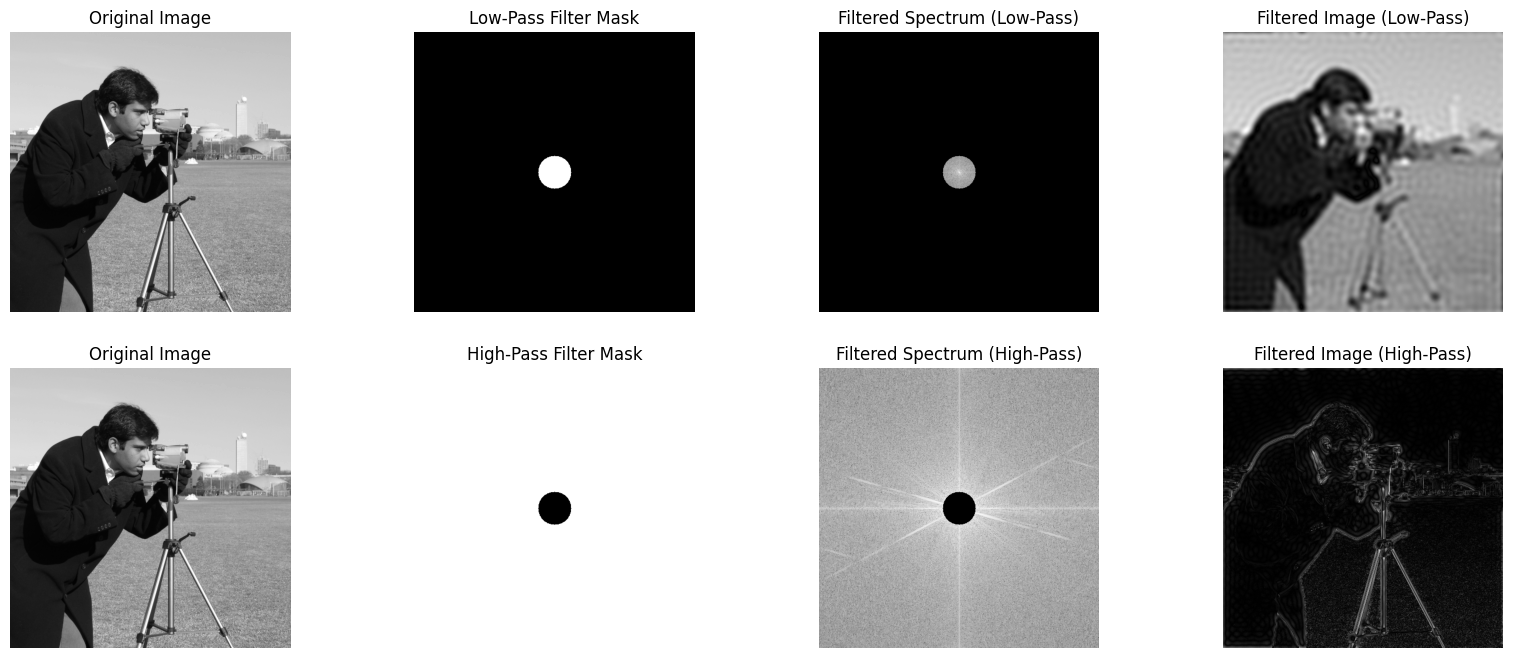

In [5]:
# Compute the Fourier Transform
F = np.fft.fft2(img_gray)
F_shifted = np.fft.fftshift(F)

# Create filter parameters
H, W = img_gray.shape
center = (H // 2, W // 2)
radius = 30

# Create circular mask
Y, X = np.ogrid[:H, :W]
distance = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
low_pass_mask = distance <= radius  # Low-Pass Filter: keep low frequencies
high_pass_mask = distance > radius  # High-Pass Filter: remove low frequencies

# Apply the filters
F_low_pass = F_shifted * low_pass_mask
F_high_pass = F_shifted * high_pass_mask

# Compute magnitude spectrum for visualization
F_low_pass_magnitude_db = 20 * np.log10(np.abs(F_low_pass) + 1)
F_high_pass_magnitude_db = 20 * np.log10(np.abs(F_high_pass) + 1)

# Inverse Fourier Transform
img_low_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(F_low_pass)))
img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(F_high_pass)))

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Low-Pass Filter
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(low_pass_mask, cmap='gray')
axes[0, 1].set_title('Low-Pass Filter Mask')
axes[0, 1].axis('off')

axes[0, 2].imshow(F_low_pass_magnitude_db, cmap='gray')
axes[0, 2].set_title('Filtered Spectrum (Low-Pass)')
axes[0, 2].axis('off')

axes[0, 3].imshow(img_low_pass, cmap='gray')
axes[0, 3].set_title('Filtered Image (Low-Pass)')
axes[0, 3].axis('off')

# High-Pass Filter
axes[1, 0].imshow(img_gray, cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(high_pass_mask, cmap='gray')
axes[1, 1].set_title('High-Pass Filter Mask')
axes[1, 1].axis('off')

axes[1, 2].imshow(F_high_pass_magnitude_db, cmap='gray')
axes[1, 2].set_title('Filtered Spectrum (High-Pass)')
axes[1, 2].axis('off')

axes[1, 3].imshow(img_high_pass, cmap='gray')
axes[1, 3].set_title('Filtered Image (High-Pass)')
axes[1, 3].axis('off')

plt.show()

_What about repeating patterns?_

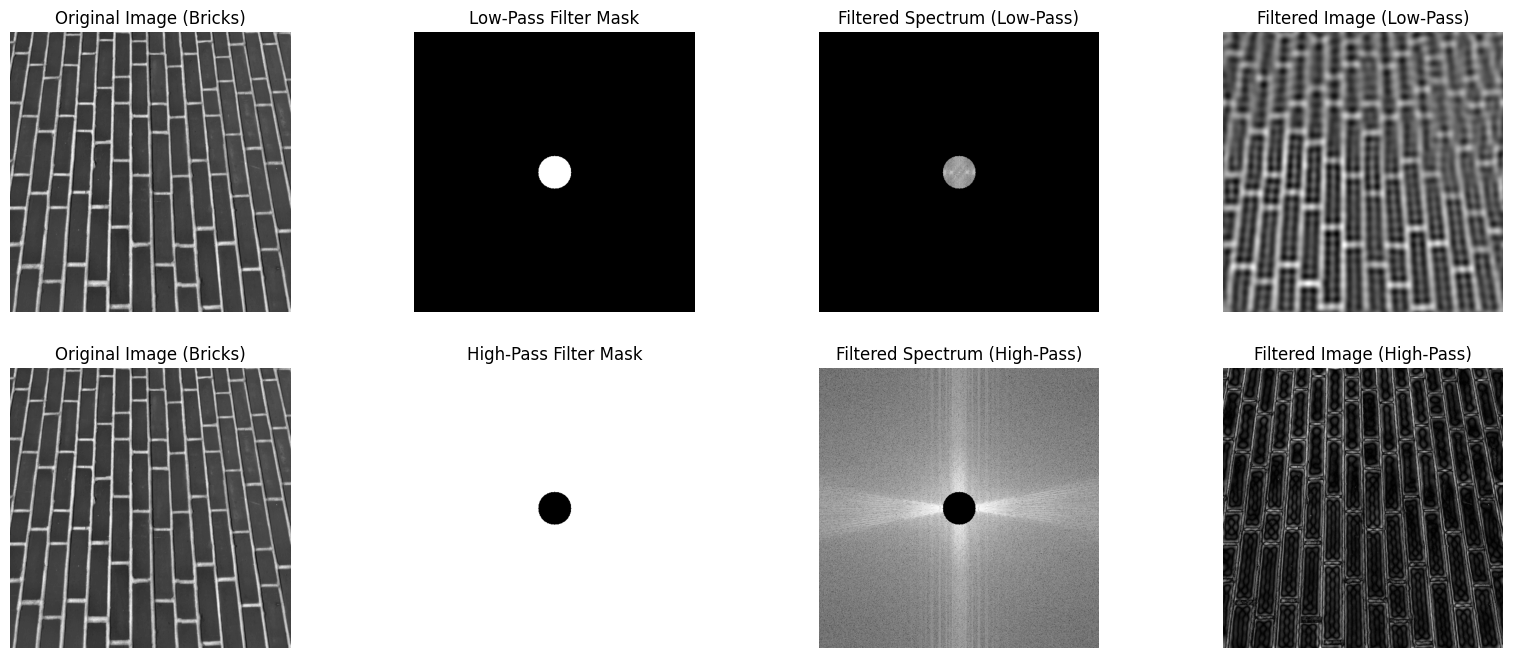

In [6]:
img_brick = data.brick()

# Compute the Fourier Transform
F_brick = np.fft.fft2(img_brick)
F_brick_shifted = np.fft.fftshift(F_brick)

# Apply the filters
F_brick_low_pass = F_brick_shifted * low_pass_mask
F_brick_high_pass = F_brick_shifted * high_pass_mask

# Compute magnitude spectrum for visualization
F_brick_low_pass_magnitude_db = 20 * np.log10(np.abs(F_brick_low_pass) + 1)
F_brick_high_pass_magnitude_db = 20 * np.log10(np.abs(F_brick_high_pass) + 1)

# Inverse Fourier Transform
img_brick_low_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(F_brick_low_pass)))
img_brick_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(F_brick_high_pass)))

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Low-Pass Filter
axes[0, 0].imshow(img_brick, cmap='gray')
axes[0, 0].set_title('Original Image (Bricks)')
axes[0, 0].axis('off')

axes[0, 1].imshow(low_pass_mask, cmap='gray')
axes[0, 1].set_title('Low-Pass Filter Mask')
axes[0, 1].axis('off')

axes[0, 2].imshow(F_brick_low_pass_magnitude_db, cmap='gray')
axes[0, 2].set_title('Filtered Spectrum (Low-Pass)')
axes[0, 2].axis('off')

axes[0, 3].imshow(img_brick_low_pass, cmap='gray')
axes[0, 3].set_title('Filtered Image (Low-Pass)')
axes[0, 3].axis('off')

# High-Pass Filter
axes[1, 0].imshow(img_brick, cmap='gray')
axes[1, 0].set_title('Original Image (Bricks)')
axes[1, 0].axis('off')

axes[1, 1].imshow(high_pass_mask, cmap='gray')
axes[1, 1].set_title('High-Pass Filter Mask')
axes[1, 1].axis('off')

axes[1, 2].imshow(F_brick_high_pass_magnitude_db, cmap='gray')
axes[1, 2].set_title('Filtered Spectrum (High-Pass)')
axes[1, 2].axis('off')

axes[1, 3].imshow(img_brick_high_pass, cmap='gray')
axes[1, 3].set_title('Filtered Image (High-Pass)')
axes[1, 3].axis('off')

plt.show()

## Image Compression
- reduce data by removing less important frequency components

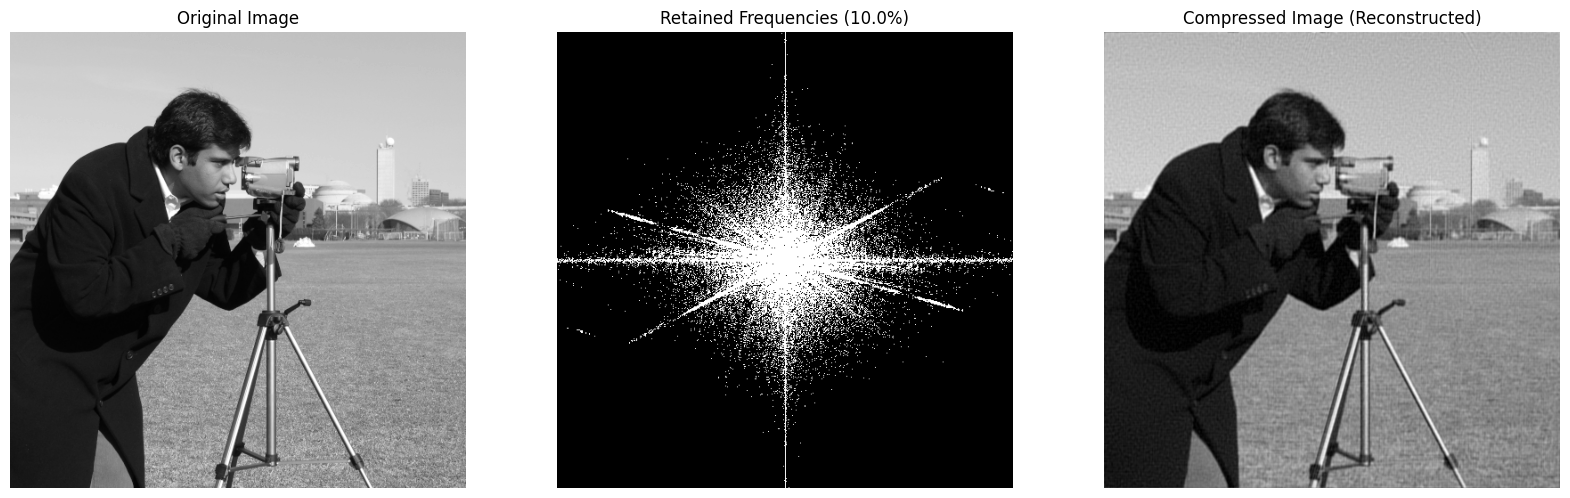

In [7]:
# Get magnitude spectrum
magnitude = np.abs(F_shifted)

# Determine threshold for keeping only the strongest frequencies
compression_ratio = 0.1
threshold = np.percentile(magnitude, 100 * (1 - compression_ratio))

# Create a mask and compress the spectrum
mask = magnitude >= threshold
F_compressed = F_shifted * mask

# Reconstruct the compressed image
F_unshifted = np.fft.ifftshift(F_compressed)
img_compressed = np.abs(np.fft.ifft2(F_unshifted))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original image
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Mask (retained frequencies)
axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f'Retained Frequencies ({compression_ratio * 100}%)')
axes[1].axis('off')

# Compressed image
axes[2].imshow(img_compressed, cmap='gray')
axes[2].set_title('Compressed Image (Reconstructed)')
axes[2].axis('off')

plt.show()

**Note:**  
The **Discrete Cosine Transform (DCT)** is preferred in real applications instead of the **Fourier Transform** because:
- it eliminates the imaginary component - more efficient for image compression and processing
- it is widely used in lossy formats like JPEG for efficient storage

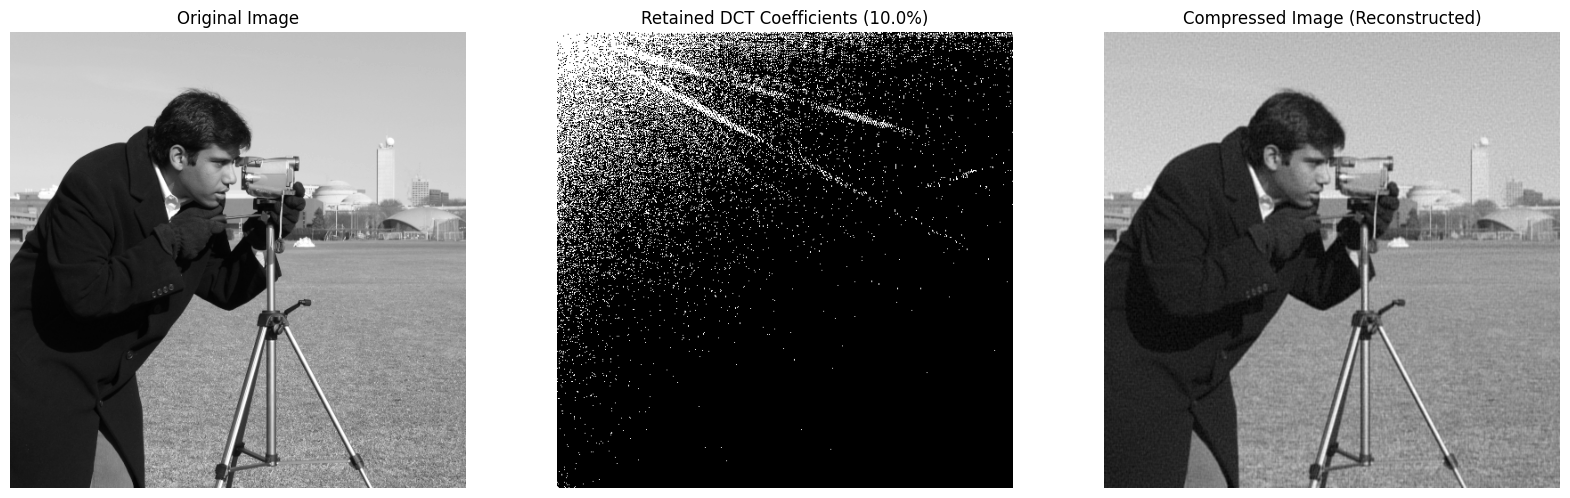

In [8]:
from scipy.fftpack import dct, idct

# Compute 2D DCT
F_dct = dct(dct(img_gray.T, norm='ortho').T, norm='ortho')

# Get magnitude spectrum
magnitude = np.abs(F_dct)

# Determine threshold for keeping only the strongest coefficients
compression_ratio = 0.1
threshold = np.percentile(magnitude, 100 * (1 - compression_ratio))

# Create a mask and compress the spectrum
mask = magnitude >= threshold
F_compressed = F_dct * mask

# Reconstruct the compressed image
img_compressed = idct(idct(F_compressed.T, norm='ortho').T, norm='ortho')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original image
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Mask (retained DCT coefficients)
axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f'Retained DCT Coefficients ({compression_ratio * 100}%)')
axes[1].axis('off')

# Compressed image
axes[2].imshow(img_compressed, cmap='gray')
axes[2].set_title('Compressed Image (Reconstructed)')
axes[2].axis('off')

plt.show()